In [10]:
import gym
import numpy as np
from tqdm.notebook import tqdm
from scipy.stats import ttest_ind 
import matplotlib.pyplot as plt

In [2]:
class Multi_Normal():
    def __init__(self, mean: np.array, cov: np.array):
        self.mean = mean
        self.cov = cov
        
    def sample(self, n):
        return np.random.multivariate_normal(self.mean, self.cov, size=(n))
    
    def update(self, mean, cov):
        self.mean = mean
        self.cov = cov

In [3]:
class Success_Matching():
    def __init__(self, n_states):
        self.n_states = n_states
        self.dist = Multi_Normal(np.zeros(self.n_states), np.eye(self.n_states))
    
    def train(
        self, 
        reward_function, 
        epochs=20, 
        population_size=10, 
        variance_optimization=False, 
        lower_bound_variance=1e-4,
        variance_decay=True,
        viz_function=False,
        verbose=True
    ):
        with tqdm(total=epochs, disable=not verbose) as pbar:
            for epoch in range(epochs):
                # sample params
                samples = self.dist.sample(population_size)

                # collect rewards
                reward_sums = [
                    reward_function(params) 
                    for params in samples
                ]

                # build success weights
                reward_sums = np.array(reward_sums)
                reward_sums_max = reward_sums.max()
                beta = 10 / (reward_sums_max - reward_sums.min() + 1e-6)
                w = np.exp(beta * (reward_sums - reward_sums_max))

                # update the distribution
                new_mean = w @ samples / w.sum()
                factor = 1
                if variance_optimization:
                    distance_to_mean = (samples - new_mean)
                    factor *= w@np.square(distance_to_mean).sum(axis=1) / w.sum()
                if variance_decay:
                    factor *= 1 / np.log(epoch + 2)
                new_cov = np.identity(self.n_states) * max(lower_bound_variance, factor)
                self.dist.update(new_mean, new_cov)
                pbar.update(1)
                pbar.set_postfix({
                    "var":new_cov[0,0], 
                    "max reward": reward_sums.max(), 
                    "mean reward": reward_sums.mean()
                })
                
                if viz_function:
                    viz_function(self.dist.mean) 
            return self.dist.mean

In [4]:
def cart_pole_v1_trial(env, params: np.array, tolerance=50, viz=True, T=300):
    state = env.reset()
    sum_reward = 0
    for _ in range(T):
        action = int(np.heaviside(np.array(state) @ params, 1))
        state, reward, done, info = env.step(action)
        sum_reward += reward
        if done:
            if tolerance > 0 and viz:
                tolerance -= 1
            else:
                break
        if viz: 
            env.render()
    return sum_reward

In [6]:
env = gym.make('CartPole-v1')

n_states = env.observation_space.shape[0]
sm = Success_Matching(n_states)

# performance before training
print("reward before training", cart_pole_v1_trial(env, sm.dist.mean, T=env._max_episode_steps))

# rollout functions
reward_function = lambda x: cart_pole_v1_trial(env, x, viz=False, T=env._max_episode_steps)
viz_function = lambda x: cart_pole_v1_trial(env, x, viz=True, T=env._max_episode_steps)

# training
best_params = sm.train(
    reward_function, 
    viz_function=viz_function, 
    population_size=5, 
    epochs=10, 
    variance_optimization=False, 
    variance_decay=True)

# performance after training
print("final reward", cart_pole_v1_trial(env, best_params, T=env._max_episode_steps))

reward before training 8.0


  0%|          | 0/10 [00:00<?, ?it/s]

final reward 336.0


### Experiment 1: Variance optimization vs variance decay
1. Testing both approaches 100 times an collecting the final reward
2. T-Test for mean difference between the groups

In [7]:
rewards_variance_optimization = []
for _ in tqdm(range(100)):
    env = gym.make('CartPole-v1')
    n_states = env.observation_space.shape[0]
    sm = Success_Matching(n_states)
    reward_function = lambda x: cart_pole_v1_trial(env, x, viz=False, T=env._max_episode_steps)
    best_params = sm.train(
        reward_function, 
        population_size=5, 
        epochs=10, 
        variance_optimization=True, 
        variance_decay=False,
        verbose=False
    )
    rewards_variance_optimization.append(cart_pole_v1_trial(env, best_params, viz=False, T=env._max_episode_steps))

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
rewards_variance_decay = []
for _ in tqdm(range(100)):
    env = gym.make('CartPole-v1')
    n_states = env.observation_space.shape[0]
    sm = Success_Matching(n_states)
    reward_function = lambda x: cart_pole_v1_trial(env, x, viz=False, T=env._max_episode_steps)
    best_params = sm.train(
        reward_function, 
        population_size=5, 
        epochs=10, 
        variance_optimization=False, 
        variance_decay=True,
        verbose=False
    )
    rewards_variance_decay.append(cart_pole_v1_trial(env, best_params, viz=False, T=env._max_episode_steps))

  0%|          | 0/100 [00:00<?, ?it/s]

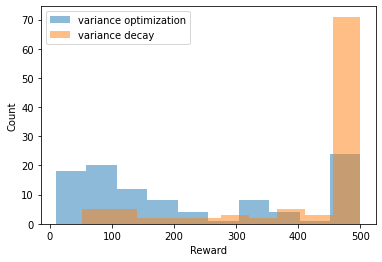

In [16]:
plt.figure()
plt.hist(rewards_variance_optimization, alpha=0.5, label="variance optimization")
plt.hist(rewards_variance_decay, alpha=0.5, label="variance decay")
plt.legend()
plt.xlabel("Reward")
plt.ylabel("Count")
plt.show()

In [9]:
ttest_ind(rewards_variance_optimization, rewards_variance_decay)

Ttest_indResult(statistic=-8.512914937663155, pvalue=4.201483499609959e-15)

### Results
The t-value is negative so the mean reward from the variance optimization group is lower than the mean of the rewards in the variance decay group. The p-value is basicly zero.